# Federated Learning on Facial Expression Recognition

Zhu He - Mike

## Abstract

Recently, I have developed a mobile game, [Best Actor Game](https://apps.apple.com/cn/app/id1498575047), which is based on computer vision model to recognize human facial expression. I have designed the computer vision model using an architecture similar to VGGNet, and the details are described here in this [article](https://github.com/mikemikezhu/facial-expression-recognition). The computer vision model, using Tensorflow Lite, was deployed locally on the mobile device. However, if we allow the face data to be trained locally on user's device, we may improve our model constantly while protecting user's data privacy. Therefore, I try to use **federated learning** to re-design the computer vision model to make facial expression prediction. This document will discuss the basic concept of federated learning, as well as how the federated learning is implemented to create a facial expression recognition model with Tensorflow.

## Federated Learning

Federated learning is a decentralized approach which allows the data to be trained locally on user devices (e.g. mobile devices). Specifically, within a large number of user devices, only a fraction of which may be available for training at a given time. Therefore, the available user devices will be used to train the data locally, and compute the update to the shared global model maintained by the server, which will aggregate all the updates from the distributed devices, and compute weight using the `FederatedAveraging` algorithm in the following math formula.

$w_{t+1}=\sum_{k=1}^K \frac{n_{k}}{n}w^{k}_{t+1}$

Considering that modern smartphones have relatively fast processors (e.g. GPUs), the computation becomes essentially free for the federated learning. Therefore, the communication costs dominate during the federated optimization. Based on the research paper from Google, we may reduce the number of rounds of communication required to train a model in the following ways.

- **Increase parallelism** by involving more clients to compute the update independently.
- **Increase computation on each client** by allowing each client to perform a more complex calculation between each communication round.

Federated learning has provided the following distinct advantages over the traditional approach to train the data in the data center.

- It helps to **protect user's data privacy**, considering that the training data (e.g. user's photo, password, etc.) will only be retained locally on the edge devices.
- It also helps to **reduce the network latency**. Since the data is trained locally, transporting large training data to the server is not necessary. Only the update of the training result will be communicated between the client and server, which greatly helps to reduce the network latency.
- It also helps to **reduce the security risks**, since the privacy data is only stored locally, and therefore will not be easily leaked to attackers when there is attacks happening on the cloud, or the communication between client and server (e.g. Man-in-the-middle attack).

Next, I will discuss how the federated learning is implemented to recognize human facial expression by using Tensorflow.

### Install Packages

First and foremost, let's install Tensorflow federated learning package.

In [0]:
# Tensorflow federated package 
!pip install --upgrade tensorflow_federated > /dev/null 2>&1

### Download Data

Next, we need to download the dataset to train the computer vision model. Here we use FER2013 dataset in [Challenges in Representation Learning: Facial Expression Recognition Challenge](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data) in Kaggle. Therefore, let's configure Kaggle API and download the training dataset.

In [0]:
import os

# Configure kaggle
os.chdir('/root/')
!mkdir -p .kaggle
os.chdir('/root/.kaggle')
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Y-o0TVcjehM8SZB3Nt8U3xkyeQu-Nse-' -O kaggle.json > /dev/null 2>&1
!ls /root/.kaggle

# Set permissions 
!chmod 600 /root/.kaggle/kaggle.json

# Create data folder
os.chdir('/content/')
!rm -rf data
!mkdir data
os.chdir('data')
!pwd

# Download data
!pip install -q kaggle
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

# Unzip data
!unzip train.csv.zip train.csv

kaggle.json
/content/data
  0% 0.00/7.01k [00:00<?, ?B/s]
100% 7.01k/7.01k [00:00<00:00, 5.90MB/s]
 84% 81.0M/96.6M [00:00<00:00, 75.3MB/s]
100% 96.6M/96.6M [00:00<00:00, 117MB/s] 
 47% 9.00M/19.3M [00:00<00:00, 42.1MB/s]
100% 19.3M/19.3M [00:00<00:00, 62.9MB/s]
 94% 86.0M/92.0M [00:00<00:00, 84.7MB/s]
100% 92.0M/92.0M [00:00<00:00, 126MB/s] 
 85% 66.0M/77.3M [00:00<00:00, 76.3MB/s]
100% 77.3M/77.3M [00:00<00:00, 121MB/s] 
Archive:  train.csv.zip
  inflating: train.csv               


### Load Data

The image dataset downloaded from Kaggle is in ".csv" file format. Therefore, we need to load the "train.csv" file, and convert it to numpy array. The training images and labels are saved in "x_train" and "y_train" respectively.

In [0]:
import csv
import numpy

train_images = []
train_labels = []

categories_count = {}

with open('train.csv') as train:

    # Read train.csv file
    csv_reader = csv.reader(train)
    next(csv_reader)  # Skip the header

    for row in csv_reader:

        # Append image
        pixels_str = row[1]
        pixels_list = [int(i) for i in pixels_str.split(' ')]
        pixels_list = numpy.array(pixels_list, dtype='uint8')
        image = pixels_list.reshape((48, 48))
        train_images.append(image)

        label_str = row[0]

        # Calculate categories count
        count = 0
        if label_str in categories_count:
            count = categories_count[label_str] + 1
        categories_count[label_str] = count

        # Append label
        label = int(label_str)
        train_labels.append(label)

# Create numpy array of train images and labels
x_train = numpy.array(train_images)
y_train = numpy.array(train_labels)

print('x_train shape: {0}'.format(x_train.shape))
print('y_train shape: {0}'.format(y_train.shape))

x_train shape: (28709, 48, 48)
y_train shape: (28709,)


Then, let's show one of the images in the dataset. Each image is grey-scale and contains 48 x 48 pixels.

Label is: 0


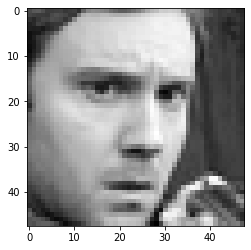

In [0]:
from matplotlib import pyplot as plt
%matplotlib inline

# Show some image
image = x_train[0]
label = y_train[0]

print('Label is: ' + str(label))
plt.imshow(image, cmap='gray')

### Preprocess Data

Next, we need to preprocess and prepare the federated data. Since the training data will be distributed in each user's local device, let's assume we have 3 clients, and each client has 5 images to train, in order to simulate the scenario.

In [0]:
%tensorflow_version 2.x
import tensorflow as tf

print('Tensorflow version: {}'.format(tf.__version__))

from tensorflow import reshape
from collections import OrderedDict

"""
Assume we have 3 clients, each client has 5 images to train
"""

# Assume each client has 5 images to train
TRAIN_DATA_PER_CLIENT = 5

# Train 3 times for each image
TRAINING_EPOCHS = 3

# Prepare training data for each client
x_client_1 = x_train[0 : TRAIN_DATA_PER_CLIENT]
y_client_1 = y_train[0 : TRAIN_DATA_PER_CLIENT]

x_client_2 = x_train[TRAIN_DATA_PER_CLIENT : TRAIN_DATA_PER_CLIENT * 2]
y_client_2 = y_train[TRAIN_DATA_PER_CLIENT : TRAIN_DATA_PER_CLIENT * 2]

x_client_3 = x_train[TRAIN_DATA_PER_CLIENT * 2 : TRAIN_DATA_PER_CLIENT * 3]
y_client_3 = y_train[TRAIN_DATA_PER_CLIENT * 2 : TRAIN_DATA_PER_CLIENT * 3]
print(x_client_3.shape)

# Prepare test data
x_test = x_train[TRAIN_DATA_PER_CLIENT * 3 : TRAIN_DATA_PER_CLIENT * 4]
y_test = y_train[TRAIN_DATA_PER_CLIENT * 3 : TRAIN_DATA_PER_CLIENT * 4]

# Create federated data
def create_federated_data(x_train, y_train):

    orderDict = OrderedDict()
    pixels_list = []
    
    x_train = x_train / 255.0
    x_train = x_train.reshape(len(x_train), 48, 48, 1)

    orderDict['x'] = numpy.array(x_train)
    orderDict['y'] = numpy.array(y_train)
    dataset = tf.data.Dataset.from_tensor_slices(orderDict)
    batch = dataset.shuffle(10).batch(5)

    return batch

federated_data_client_1 = [create_federated_data(x_client_1, y_client_1) for epoch in range(TRAINING_EPOCHS)]
federated_data_client_2 = [create_federated_data(x_client_2, y_client_2) for epoch in range(TRAINING_EPOCHS)]
federated_data_client_3 = [create_federated_data(x_client_3, y_client_3) for epoch in range(TRAINING_EPOCHS)]

federated_data_test = [create_federated_data(x_test, y_test) for epoch in range(TRAINING_EPOCHS)]

print('Total training epochs: {}'.format(len(federated_data_client_3)))

Tensorflow version: 2.1.0
(5, 48, 48)
Total training epochs: 3


### Create Model

By referring to VGGNet architecture, we have designed the computer vision model with several stacks of layers. The model will have the following components:
- Convolutional layers: These layers are the building blocks of our architecture, which learns the image feature by computing the dot product between the weights and the small region on the image. Similar to VGGNet architecture, all the convolutional layers are designed with 3 x 3 kernal size, and several filters.
- Activation functions: The activation functions are those functions which are applied to the outputs of the layers in the network. Specifically, we use ReLU (Rectified Linear Unit) activation function to increase the non-linearity of the network. Besides, a Softmax function will be used to compute the probability of each category.
- Pooling layers: These layers will down-sample the image to reduce the spatial data and extract features. In our model, we will use Max Pooling with A 3 x 3 pooling size and a 2 x 2 stride.
- Dense layers: The dense layers are stacked as the fully connected layers of the network, which take in the feature data from the previous convolutional layers and perform decision making.
- Dropout layers: The dropout layers are used to prevent over-fitting when training the model.
- Batch normalization: This technique can be used to speed up learning by normalizing the output of the previous activation layer. 

The diagram of the model is displayed as follows.

![cnn](https://drive.google.com/uc?id=1jjORxRgvEDDMLZ-mX5JkCnUWUFn7IHpL)

Our model contains 5 stacks of layers. In each of the first 4 stacks of layers, there are 2 convolutional layer followed by 1 pooling layer. Besides, we use batch normalization to speed up training and dropout to prevent over-fitting. Then we have one stack of 3 fully-connected layers, followed by a Softmax activation function, which generates the probability of the facial expression categories. Finally, we compile our model using Adam optimizer with a certain learning rate. Considering that we are dealing with classification issue, we will use `sparse_categorical_crossentropy` as the loss function.

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

def create_keras_model():

    # Create keras model
    model = Sequential()

    # 1st convolution layer
    model.add(Conv2D(64, input_shape=(48, 48, 1), kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, padding='same', kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(Dropout(0.3))

    # 2nd convolution layer
    model.add(Conv2D(128, padding='same', kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, padding='same', kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(Dropout(0.3))

    # 3rd convolution layer
    model.add(Conv2D(256, padding='same', kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, padding='same', kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(Dropout(0.3))

    # 4th convolution layer
    model.add(Conv2D(512, padding='same', kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, padding='same', kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(Dropout(0.3))

    # Fully connected layer
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(7, activation='softmax'))

    # Compile the model
    model.compile(loss=SparseCategoricalCrossentropy(),
                  optimizer=SGD(learning_rate=0.02),
                  metrics=[SparseCategoricalAccuracy()])
    
    return model

# Summary model
keras_model = create_keras_model()
keras_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 128)       7

Next, wrap our compiled Keras model in an instance of the `tff.learning.Model` interface, in order to use the Tensorflow federated learning.

In [0]:
import tensorflow_federated as tff

# Create dummy batch
dummy_batch = tf.nest.map_structure(lambda x: x.numpy(), iter(federated_data_client_1[0]).next())
print(dummy_batch['x'].shape)

def create_federated_model():

    # Create keras model
    keras_model = create_keras_model()
    
    # Convert keras model to federated model
    return tff.learning.from_compiled_keras_model(keras_model, dummy_batch)

(5, 48, 48, 1)


### Train Model

Then, we need to build federated averate process and start training.

In [0]:
# Build federated average process
trainer = tff.learning.build_federated_averaging_process(create_federated_model)

# Create initial state
train_state = trainer.initialize()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autoc

========== Train on Local Device of Client 1 ==========
round  0, metrics=<sparse_categorical_accuracy=0.3333333432674408,loss=3.2094497680664062>
round  1, metrics=<sparse_categorical_accuracy=0.7333333492279053,loss=0.9364567995071411>
round  2, metrics=<sparse_categorical_accuracy=0.6666666865348816,loss=0.812284529209137>
round  3, metrics=<sparse_categorical_accuracy=0.6000000238418579,loss=0.8869265913963318>
round  4, metrics=<sparse_categorical_accuracy=0.6666666865348816,loss=0.6965619325637817>
round  5, metrics=<sparse_categorical_accuracy=0.800000011920929,loss=0.5766454935073853>


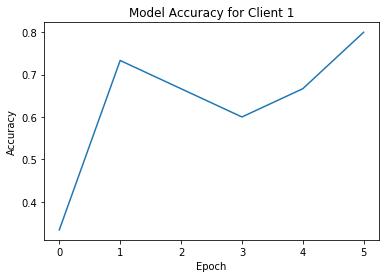

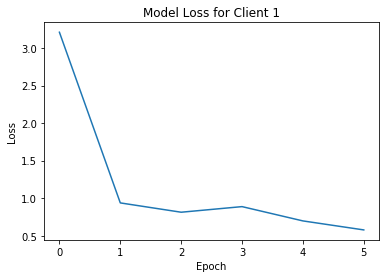

In [0]:
# Train on federated model
print('========== Train on Local Device of Client 1 ==========')

history_accuracy_1 = []
history_loss_1 = []

for round_num in range(6):
    train_state, train_metrics = trainer.next(train_state, federated_data_client_1)
    history_accuracy_1.append(train_metrics.sparse_categorical_accuracy)
    history_loss_1.append(train_metrics.loss)
    print('round {:2d}, metrics={}'.format(round_num, train_metrics))

# Show accuracy diagram
plt.title('Model Accuracy for Client 1')
plt.plot(history_accuracy_1, label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Show loss diagram
plt.title('Model Loss for Client 1')
plt.plot(history_loss_1, label='loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

========== Train on Local Device of Client 2 ==========
round  0, metrics=<sparse_categorical_accuracy=0.06666667014360428,loss=8.141902923583984>
round  1, metrics=<sparse_categorical_accuracy=0.20000000298023224,loss=1.9447388648986816>
round  2, metrics=<sparse_categorical_accuracy=0.800000011920929,loss=0.5845308899879456>
round  3, metrics=<sparse_categorical_accuracy=0.800000011920929,loss=0.49472060799598694>
round  4, metrics=<sparse_categorical_accuracy=0.7333333492279053,loss=0.5940064787864685>
round  5, metrics=<sparse_categorical_accuracy=0.8666666746139526,loss=0.39928290247917175>


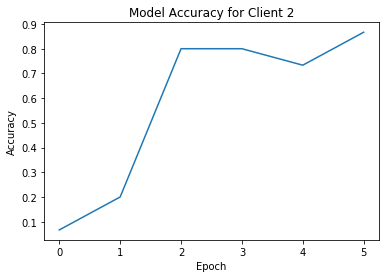

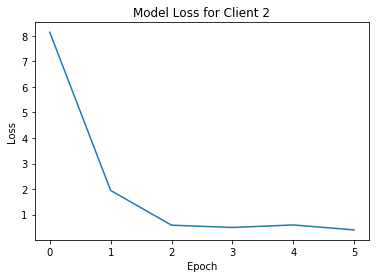

In [0]:
# Train on federated model
print('========== Train on Local Device of Client 2 ==========')

history_accuracy_2 = []
history_loss_2 = []

for round_num in range(6):
    train_state, train_metrics = trainer.next(train_state, federated_data_client_2)
    history_accuracy_2.append(train_metrics.sparse_categorical_accuracy)
    history_loss_2.append(train_metrics.loss)
    print('round {:2d}, metrics={}'.format(round_num, train_metrics))

# Show accuracy diagram
plt.title('Model Accuracy for Client 2')
plt.plot(history_accuracy_2, label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Show loss diagram
plt.title('Model Loss for Client 2')
plt.plot(history_loss_2, label='loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

========== Train on Local Device of Client 3 ==========
round  0, metrics=<sparse_categorical_accuracy=0.0,loss=5.371275901794434>
round  1, metrics=<sparse_categorical_accuracy=0.3333333432674408,loss=2.1037437915802>
round  2, metrics=<sparse_categorical_accuracy=0.6000000238418579,loss=1.1378229856491089>
round  3, metrics=<sparse_categorical_accuracy=0.6000000238418579,loss=1.1078845262527466>
round  4, metrics=<sparse_categorical_accuracy=0.7333333492279053,loss=0.6068843603134155>
round  5, metrics=<sparse_categorical_accuracy=1.0,loss=0.2441573590040207>


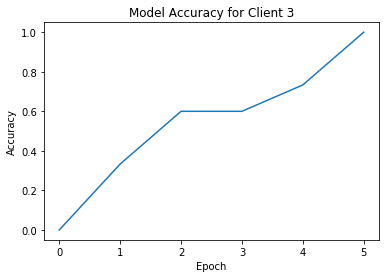

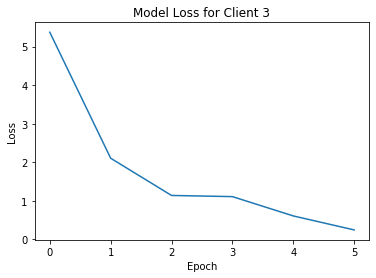

In [0]:
# Train on federated model
print('========== Train on Local Device of Client 3 ==========')

history_accuracy_3 = []
history_loss_3 = []

for round_num in range(6):
    train_state, train_metrics = trainer.next(train_state, federated_data_client_3)
    history_accuracy_3.append(train_metrics.sparse_categorical_accuracy)
    history_loss_3.append(train_metrics.loss)
    print('round {:2d}, metrics={}'.format(round_num, train_metrics))

# Show accuracy diagram
plt.title('Model Accuracy for Client 3')
plt.plot(history_accuracy_3, label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Show loss diagram
plt.title('Model Loss for Client 3')
plt.plot(history_loss_3, label='loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### Evaluate Model

Last but not least, let's evaluate the model after federated training process.

In [0]:
evaluator = tff.learning.build_federated_evaluation(create_federated_model)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [0]:
test_metrics = evaluator(train_state.model, federated_data_test)
print(test_metrics)

<sparse_categorical_accuracy=0.20000000298023224,loss=6.025786399841309>


## Further Thinking

During the federated training process, I have come up with the following thoughts which might consider to improve the federated training in the future.

- Early stopping on federated training: 

**Early stopping** strategy is generally used to stop the training process when there is no obvious improvement in the validation process. Therefore, I would suggest that early stopping shall also be integrated in the federated training process. For example, the shared model in the centralized server may reject the client's update when the validation process reaches a certain plateau.

- Centralized server handling upon receiving large amount of local update: 

There is a shared model in the centralized server constantly receiving the update from the clients. However, if there are multiple clients simultaneously update to the model of the centralized server, it might significantly increase the burder of the server load. Therefore, I would suggest to use a **Message Queue** (e.g. RabbitMQ, or Kafka) to reduce server load. Besides, instead of using one shared model in one single server, we could copy several instances of models in multiple paralleled servers, and compute the model update in parallel using **Load Balancing** techniques.

- Future application of federate learning: 

We may also consider to perform federated learning in distributed devices other than user devices (e.g. mobile devices). For example, a **Content Delivery Network (CDN)** is generally used to provide fast internet delivery through a geographically distributed group of servers. Therefore, I would suggest that we may also conduct machine learning training in these servers in the CDN network, and inform the model update to other server nodes by using **Gossip Protocol** strategy.

## Conclusion

To put it in a nutshell, this document has introduced the concept of federated learning, and the implementation of federated training to create a computer vision model for facial expression recognition.

## Reference

- [Communication-Efficient Learning of Deep Networks from Decentralized Data](https://arxiv.org/pdf/1602.05629.pdf)
- [Federated Learning for Image Classification](https://www.tensorflow.org/federated/tutorials/federated_learning_for_image_classification#evaluation)
- [TensorFlow Federated: Machine Learning on Decentralized Data](https://www.tensorflow.org/federated)
- [Facial Expression Recognition Challenge using Convolutional Neural Network](https://mikemikezhu.github.io/dev/2020/02/11/facial_expression_recognition.html)
- [Challenges in Representation Learning: Facial Expression Recognition Challenge](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data)
- [Best Actor Game](https://apps.apple.com/cn/app/id1498575047)
- [Globally Distributed Content Delivery](https://people.cs.umass.edu/~ramesh/Site/PUBLICATIONS_files/DMPPSW02.pdf)
- [Gossip Protocol](https://en.wikipedia.org/wiki/Gossip_protocol)
- [Early Stopping](https://en.wikipedia.org/wiki/Early_stopping)
- [Performance Tradeoffs in Static and Dynamic Load Balancing Strategies](https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/19860014876.pdf)